# Subclassification Impact Estimation

This notebook demonstrates **subclassification (stratification) impact estimation** using `evaluate_impact()`.

Subclassification stratifies observations into strata based on covariate quantiles, computes within-stratum treatment effects, and aggregates via weighted average.

## Workflow Overview

1. User provides `products.csv`
2. User configures `DATA.ENRICHMENT` for treatment assignment
3. User calls `evaluate_impact(config.yaml)`
4. Engine handles everything internally (adapter, enrichment, model)

## Setup

In [1]:
import json
from pathlib import Path

import pandas as pd
from impact_engine import evaluate_impact, parse_config_file
from impact_engine.metrics import create_metrics_manager
from impact_engine.models.factory import get_model_adapter
from online_retail_simulator import simulate

## Step 1: Create Products Catalog

In production, this would be your actual product catalog.

In [2]:
output_path = Path("output/demo_subclassification")
output_path.mkdir(parents=True, exist_ok=True)

job_info = simulate("configs/demo_subclassification_catalog.yaml", job_id="catalog")
products = job_info.load_df("products")

print(f"Generated {len(products)} products")
print(f"Products catalog: {job_info.get_store().full_path('products.csv')}")
products.head()

Generated 5000 products
Products catalog: /home/peisenha/office/business/eisenhauer-io/tools/impact-engine-measure/documentation/notebooks/output/demo_subclassification/catalog/products.csv


,product_identifier,category,price
0,B1P4DZHDS9,Electronics,686.37
1,B1SE4QSNG7,Toys & Games,80.75
2,BXTPQIDT5C,Food & Beverage,42.02
3,B3F1ZMC8Q6,Food & Beverage,33.42
4,B2NQRBTF0Y,Toys & Games,27.52


## Step 2: Configure Subclassification

Configure the impact engine with:
- **ENRICHMENT**: Treatment assignment via quality boost (50/50 split)
- **MODEL**: `subclassification` with price as covariate

Single-day simulation (`start_date = end_date`) produces cross-sectional data required by subclassification.

In [3]:
config_path = "configs/demo_subclassification.yaml"
baseline_config_path = "configs/demo_subclassification_baseline.yaml"

## Step 3: Run Impact Evaluation

A single call to `evaluate_impact()` handles everything:
- Engine creates CatalogSimulatorAdapter
- Adapter simulates metrics (single-day, cross-sectional)
- Adapter applies enrichment (treatment assignment + revenue boost)
- SubclassificationAdapter stratifies on price, computes per-stratum effects

In [4]:
results_path = evaluate_impact(config_path, str(output_path), job_id="results")
print(f"Results saved to: {results_path}")

Results saved to: /home/peisenha/office/business/eisenhauer-io/tools/impact-engine-measure/documentation/notebooks/output/demo_subclassification/results/impact_results.json


## Step 4: Review Results

In [5]:
with open(results_path) as f:
    results = json.load(f)

data = results["data"]
estimates = data["impact_estimates"]
summary = data["model_summary"]

print("=" * 60)
print("SUBCLASSIFICATION IMPACT ESTIMATION RESULTS")
print("=" * 60)

print(f"\nModel Type: {results['model_type']}")
print(f"Estimand:   {summary['estimand']}")

print("\n--- Impact Estimates ---")
print(f"Treatment Effect:    {estimates['treatment_effect']:.4f}")
print(f"Strata Used:         {estimates['n_strata']}")
print(f"Strata Dropped:      {estimates['n_strata_dropped']}")

print("\n--- Model Summary ---")
print(f"Observations:        {summary['n_observations']}")
print(f"Treated:             {summary['n_treated']}")
print(f"Control:             {summary['n_control']}")

SUBCLASSIFICATION IMPACT ESTIMATION RESULTS

Model Type: subclassification
Estimand:   att

--- Impact Estimates ---
Treatment Effect:    1.8983
Strata Used:         5
Strata Dropped:      0

--- Model Summary ---
Observations:        5000
Treated:             2500
Control:             2500


In [6]:
# Per-stratum details artifact
results_dir = Path(results_path).parent
stratum_path = results_dir / "subclassification__stratum_details.parquet"
stratum_df = pd.read_parquet(stratum_path)

print("--- Per-Stratum Breakdown ---")
print("-" * 70)
print(
    f"{'Stratum':<10} {'Treated':<10} {'Control':<10} {'Mean T':<12} {'Mean C':<12} {'Effect':<12}"
)
print("-" * 70)
for _, row in stratum_df.iterrows():
    print(
        f"{row['stratum']:<10} {row['n_treated']:<10} {row['n_control']:<10} "
        f"{row['mean_treated']:<12.2f} {row['mean_control']:<12.2f} {row['effect']:<12.2f}"
    )

print("\n" + "=" * 60)
print("Demo Complete!")
print("=" * 60)

--- Per-Stratum Breakdown ---
----------------------------------------------------------------------
Stratum    Treated    Control    Mean T       Mean C       Effect      
----------------------------------------------------------------------
0          481        520        4.64         4.67         -0.03       
1          501        499        9.65         7.21         2.44        
2          510        489        14.72        14.26        0.47        
3          509        491        39.59        37.16        2.44        
4          499        501        133.69       129.57       4.12        

Demo Complete!


## Step 5: Truth Recovery Validation

Compare the model's estimate against the **true causal effect** computed from counterfactual vs factual data.

In [ ]:
def calculate_true_effect(
    baseline_metrics: pd.DataFrame,
    enriched_metrics: pd.DataFrame,
) -> dict:
    """Calculate TRUE ATT by comparing per-product revenue for treated products."""
    treated_ids = enriched_metrics[enriched_metrics["enriched"]]["product_id"].unique()

    enriched_treated = enriched_metrics[enriched_metrics["product_id"].isin(treated_ids)]
    baseline_treated = baseline_metrics[baseline_metrics["product_id"].isin(treated_ids)]

    enriched_mean = enriched_treated.groupby("product_id")["revenue"].mean().mean()
    baseline_mean = baseline_treated.groupby("product_id")["revenue"].mean().mean()
    treatment_effect = enriched_mean - baseline_mean

    return {
        "enriched_mean": float(enriched_mean),
        "baseline_mean": float(baseline_mean),
        "treatment_effect": float(treatment_effect),
    }

In [8]:
parsed_baseline = parse_config_file(baseline_config_path)
baseline_manager = create_metrics_manager(parsed_baseline)
baseline_metrics = baseline_manager.retrieve_metrics(products)

parsed_enriched = parse_config_file(config_path)
enriched_manager = create_metrics_manager(parsed_enriched)
enriched_metrics = enriched_manager.retrieve_metrics(products)

print(f"Baseline records: {len(baseline_metrics)}")
print(f"Enriched records: {len(enriched_metrics)}")

Baseline records: 5000
Enriched records: 5000


In [9]:
true_effect = calculate_true_effect(baseline_metrics, enriched_metrics)

true_te = true_effect["treatment_effect"]
model_te = estimates["treatment_effect"]

if true_te != 0:
    recovery_accuracy = (1 - abs(1 - model_te / true_te)) * 100
else:
    recovery_accuracy = 100 if model_te == 0 else 0

print("=" * 60)
print("TRUTH RECOVERY VALIDATION")
print("=" * 60)
print(f"True treatment effect:  {true_te:.4f}")
print(f"Model estimate:         {model_te:.4f}")
print(f"Recovery accuracy:      {max(0, recovery_accuracy):.1f}%")
print("=" * 60)

TRUTH RECOVERY VALIDATION
True treatment effect:  0.0000
Model estimate:         1.8983
Recovery accuracy:      0.0%


### Convergence Analysis

How does the estimate converge to the true effect as sample size increases?

In [14]:
sample_sizes = [20, 50, 100, 200, 300, 500, 1500]
estimates_list = []
truth_list = []

parsed = parse_config_file(config_path)
measurement_config = parsed["MEASUREMENT"]
all_product_ids = enriched_metrics["product_id"].unique()

for n in sample_sizes:
    subset_ids = all_product_ids[:n]
    enriched_sub = enriched_metrics[enriched_metrics["product_id"].isin(subset_ids)]
    baseline_sub = baseline_metrics[baseline_metrics["product_id"].isin(subset_ids)]

    true = calculate_true_effect(baseline_sub, enriched_sub)
    truth_list.append(true["treatment_effect"])

    model = get_model_adapter("subclassification")
    model.connect(measurement_config["PARAMS"])
    result = model.fit(data=enriched_sub)
    estimates_list.append(result.data["impact_estimates"]["treatment_effect"])

print("Convergence analysis complete.")

Stratum '1' lacks common support (treated=4, control=0). Dropping.
Stratum '2' lacks common support (treated=4, control=0). Dropping.


Convergence analysis complete.


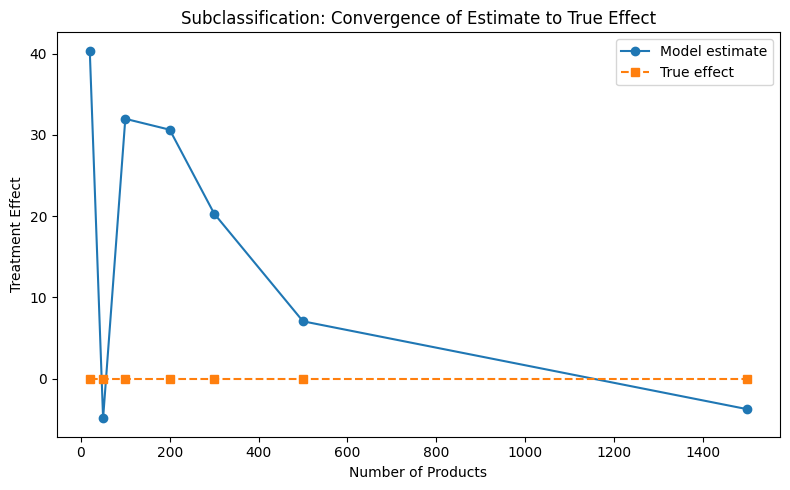

In [15]:
from notebook_support import plot_convergence

plot_convergence(
    sample_sizes,
    estimates_list,
    truth_list,
    xlabel="Number of Products",
    ylabel="Treatment Effect",
    title="Subclassification: Convergence of Estimate to True Effect",
)